What can we learn about different hosts and areas?
What can we learn from predictions? (ex: locations, prices, reviews, etc)
Which hosts are the busiest and why?
Is there any noticeable difference of traffic among different areas and what could be the reason for it?

What factors would make an Airbnb location have the highest chance to be chosen and reviewed to be able to be the most profitable for location.



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import re
from string import punctuation


#Load in data from csv
airbnb_df = pd.read_csv("../data/airbnb.csv")

#data cleaning dropping rows where no reviews are known
airbnb_df = airbnb_df.dropna(subset=["last_review", "reviews_per_month"])

#fill in null values of host_name and name
airbnb_df.fillna({"host_name": "Unknown", "name": "Unknown"}, inplace=True)

#rename name column to listing to better define
airbnb_df.rename(columns={"name": "listing"}, inplace=True)


#counting how many rows each neighborhood has
grp_by_neighborhood_counts = airbnb_df.groupby("neighbourhood_group")["number_of_reviews"].count()
grp_by_neighborhood_counts



neighbourhood_group
Bronx              876
Brooklyn         16447
Manhattan        16632
Queens            4574
Staten Island      314
Name: number_of_reviews, dtype: int64

In [ ]:
#max and min number of reviews by neighborhood
grp_by_neighborhood_max_reviews = airbnb_df.groupby("neighbourhood_group")["number_of_reviews"].max()
grp_by_neighborhood_min_reviews = airbnb_df.groupby("neighbourhood_group")["number_of_reviews"].min()
grp_by_neighborhood_max_reviews, grp_by_neighborhood_min_reviews

(neighbourhood_group
 Bronx            321
 Brooklyn         488
 Manhattan        607
 Queens           629
 Staten Island    333
 Name: number_of_reviews, dtype: int64,
 neighbourhood_group
 Bronx            1
 Brooklyn         1
 Manhattan        1
 Queens           1
 Staten Island    1
 Name: number_of_reviews, dtype: int64)

In [33]:

#Creating sub dfs based on the neighborhood group for better comparisons
bronx_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Bronx"]
brooklyn_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Brooklyn"]
manhattan_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Manhattan"]
queens_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Queens"]
staten_island_airbnb_df = airbnb_df[airbnb_df["neighbourhood_group"] == "Staten Island"]

In [ ]:
#two methods to remove punctuation re more efficient
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '',text)

def also_remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in punctuation])

# method that finds top ten percent of reviews overall and per month
# aka top performers of reviews
def find_top_ten_percent(df):
    """ 
    Finds top 10 percent of airbnb host based on
    number_of_reviews, reviews_per_month

    Parameters
    ----------
    df: DataFrame of airbnb information
    
    Returns
    -------
    top_ten_month: DataFrame that has top performers in the top 10 percent 
    by number_of_reviews AND reviews_per_month
    """
    percentile_90_nor = df['number_of_reviews'].quantile(0.90)
    percentile_90_nor_m = df['reviews_per_month'].quantile(0.90)
    top_ten = df[df['number_of_reviews']> percentile_90_nor]
    top_ten_month = top_ten[top_ten['reviews_per_month'] > percentile_90_nor_m]
    return top_ten_month

#method that retrieves the top fifteen most used words in the listing
#after cleaning the data 
def get_top_fifteen_words(df):
    """ 
    Retrieves the top fifteen most common words (excluding stopwords)
    
    remove cases and punctuation from listing creating a new column in def
    called listing processed. Then take the listing processed column and 
    expands into a single column of strings. Then 


    Parameters
    ----------
    df: dataFrame of airbnb information

    Returns
    -------
    top_15_words: Series of the 15 most common words (index) and their count (values)

    """

    df.loc[:,"listing_processed"] = df["listing"].str.lower().apply(remove_punctuation)
    all_words = df["listing_processed"].str.split(expand=True).stack()
    #records the value_counts of each word
    word_counts = all_words.value_counts()
    word_counts = pd.DataFrame(word_counts).apply(remove_stop_words, axis=1)
    sorted_word_counts = word_counts.sort_values(ascending=False)
    top_15_words = sorted_word_counts.head(15)
    return top_15_words

def remove_stop_words(x):
    """ 
    Changes the count value to 0 if index is in stopwords
    to remove it from consideration as part of most common
    due to the words being conjunctions

    Parameters
    ----------
    x: a word(str) in the listing
    
    Returns
    -------
    0 if index is in stopwords
    x["count"] if index not in stopwords
    
    """
    stopwords = ["and", "in", "on", "the", "to", "by", "with", "near", "1", "2", "of", "from"]
    if x.name in stopwords:
        return 0
    else:
        return x["count"]



def get_top_performers_top_fifteen_words(df):
    """ 
    Combining the two methods of find top performers and top 15 words in listing

    Parameters
    ----------
    df: dataFrame of airbnb information
    
    Returns
    -------
    top_ten_df, top_fifteen_words: a tuple where first element is df of top performers
    and the second is a Series which has 15 most common words and their counts
    
    """
    top_ten_df = find_top_ten_percent(df)
    top_fifteen_words = get_top_fifteen_words(top_ten_df)
    return top_ten_df, top_fifteen_words
    
#retrieve top performers and there most common words for all neighborhood groups
top_performers_bronx, top_15_words_bronx = get_top_performers_top_fifteen_words(bronx_airbnb_df)
top_performers_brooklyn, top_15_words_brooklyn = get_top_performers_top_fifteen_words(brooklyn_airbnb_df)
top_performers_manhattan, top_15_words_manhattan = get_top_performers_top_fifteen_words(manhattan_airbnb_df)
top_performers_queens, top_15_words_queens = get_top_performers_top_fifteen_words(queens_airbnb_df)
top_performers_staten_island, top_15_words_staten_island = get_top_performers_top_fifteen_words(staten_island_airbnb_df)
top_performers_overall, top_15_words_overall = get_top_performers_top_fifteen_words(airbnb_df)


In [49]:
#Testing purposes
#stopwords = ["and", "in", "on", "the", "to"]
#top_10_words_bronx[top_10_words_bronx.index.isin(stopwords)] = 0



In [ ]:
def make_bar_graph_word_counts(series, name_str):
    """ 
    Create bar graph of most common 15 words in the airbnb series


    Parameters
    ----------
    series: Series that has information about top 15 most common words
    name_str: name of the Title for the graph 
    
    """
    fig, axs = plt.subplots(figsize = (12,4))
    axs.barh(series.index, series.values, color = "lightblue", edgecolor = "black")
    axs.set_xlabel('Top 15 Words')
    axs.set_ylabel('Frequency')
    axs.set_title(f"Top 15 Most Common Word In Top Performers In {name_str}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

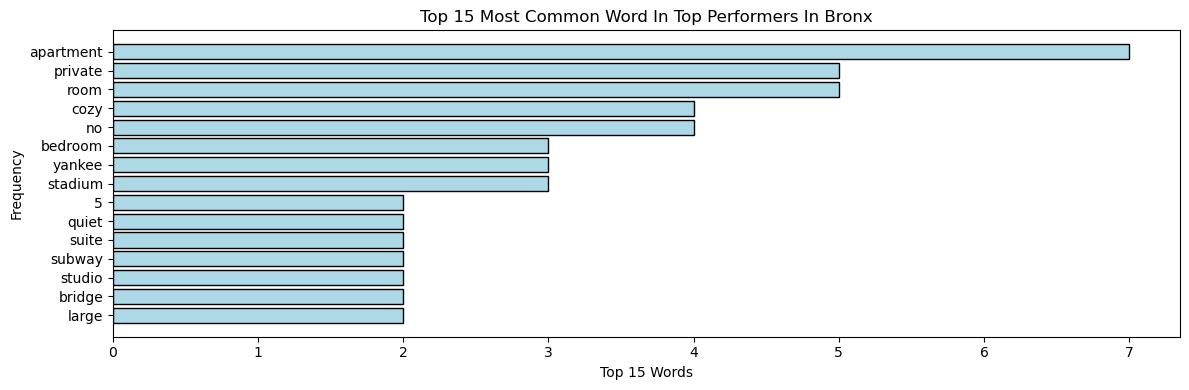

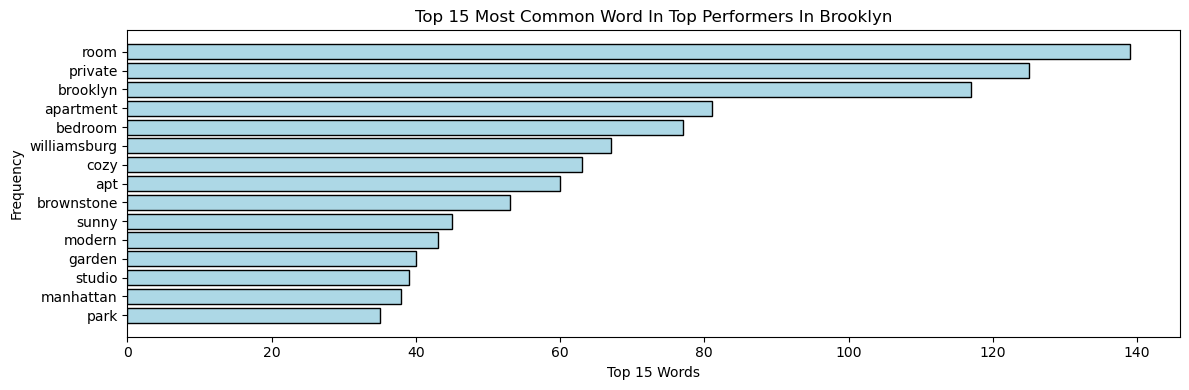

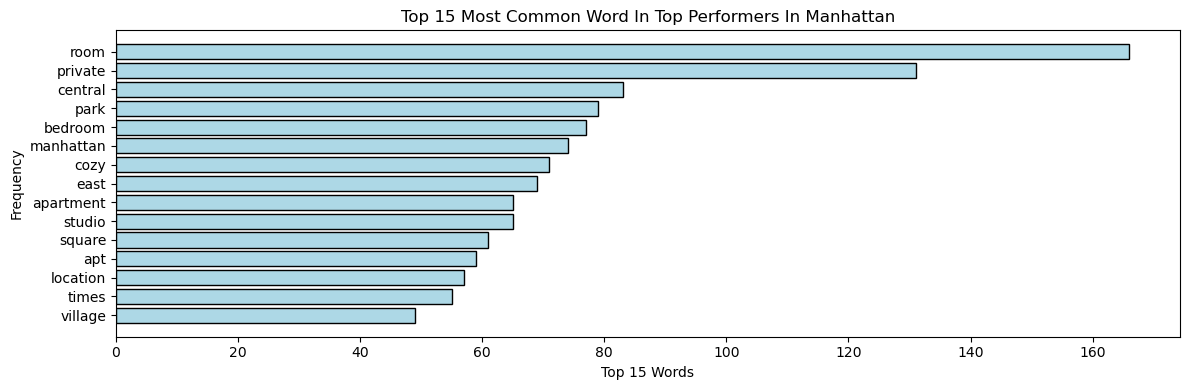

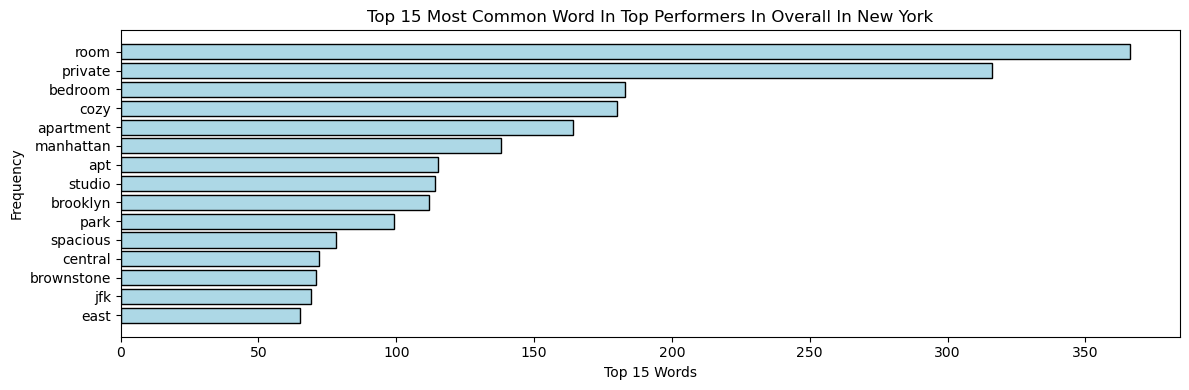

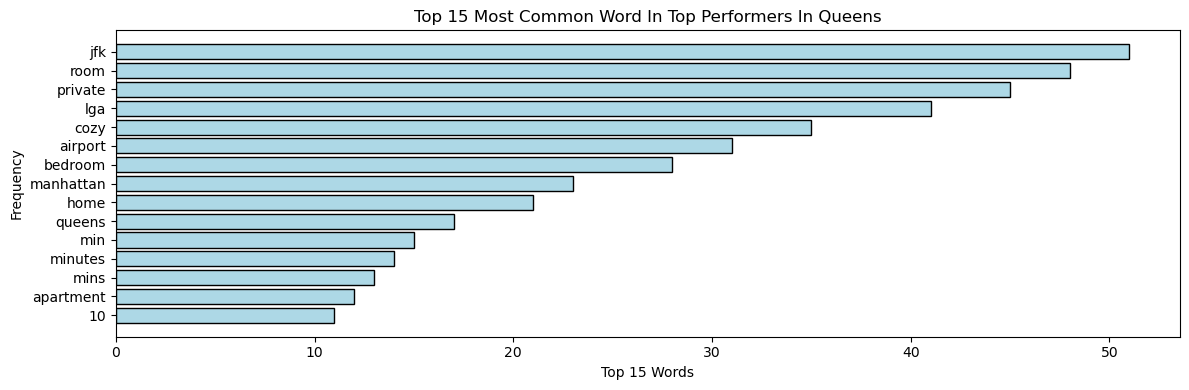

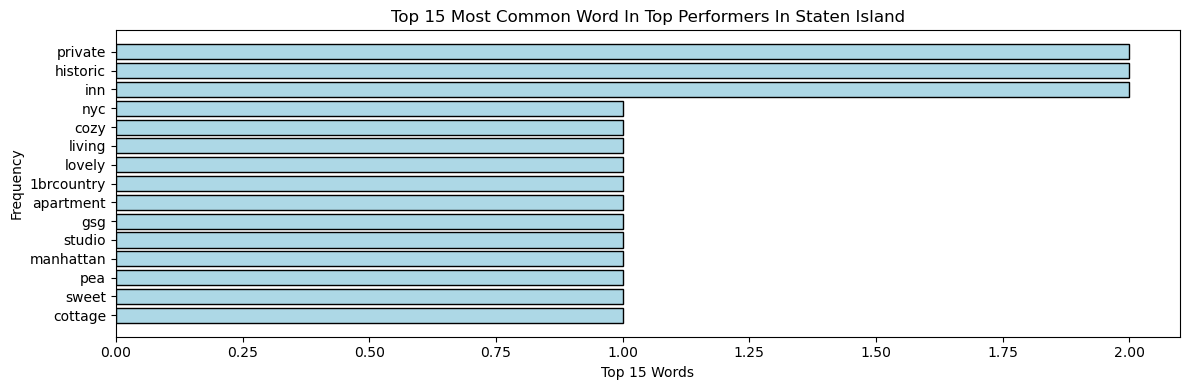

In [47]:
#Create the bar graphs for data
make_bar_graph_word_counts(top_15_words_bronx, "Bronx")
make_bar_graph_word_counts(top_15_words_brooklyn, "Brooklyn")
make_bar_graph_word_counts(top_15_words_manhattan, "Manhattan")
make_bar_graph_word_counts(top_15_words_overall, "Overall In New York")
make_bar_graph_word_counts(top_15_words_queens, "Queens")
make_bar_graph_word_counts(top_15_words_staten_island, "Staten Island")

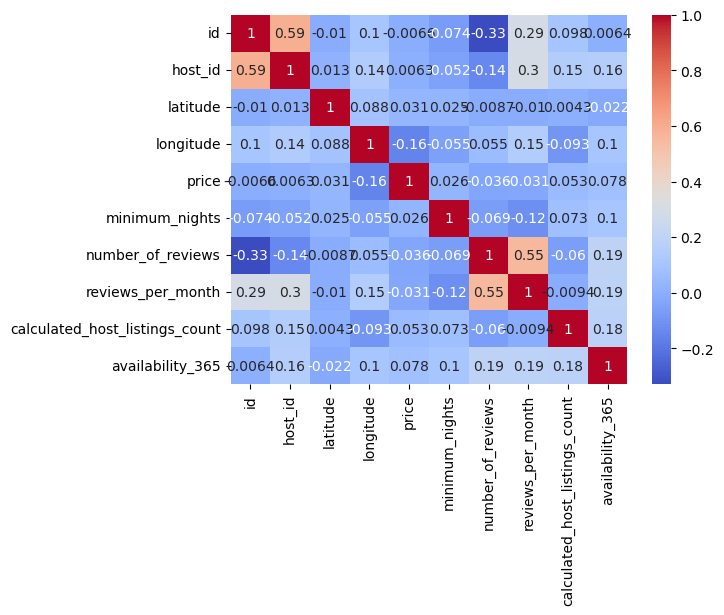

In [51]:
sns.heatmap(airbnb_df.corr(numeric_only = True), annot = True, cmap ="coolwarm")
plt.show()